In [23]:
import matplotlib.pyplot as plt
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import tensorflow as tf 
import tensorboard as tb 
import pickle
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [24]:
data = pd.read_csv('drive/MyDrive/data_processed_plant_item_new_vars_15_03_22.csv')

In [25]:
data = data.fillna(0)

In [26]:
print(list(data.timeseries.unique()[0:100]))

[80, 82, 83, 84, 86, 88, 103, 104, 105, 106, 107, 109, 116, 118, 119, 120, 121, 134, 136, 137, 138, 140, 141, 142, 143, 144, 145, 148, 155, 156, 157, 158, 159, 160, 183, 184, 185, 186, 187, 188, 204, 205, 206, 207, 208, 214, 215, 216, 217, 218, 222, 223, 224, 225, 226, 239, 240, 241, 242, 243, 250, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 263, 264, 265, 266, 267, 273, 274, 275, 276, 277, 279, 292, 296, 297, 298, 299, 302, 303, 307, 314, 315, 316, 317, 318, 319, 321, 322, 323, 324]


In [27]:
data.shape

(365785, 32)

In [28]:
print(data['time_idx'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]


In [29]:
print(data.columns.values)

['Unnamed: 0' 'index' 'ParentItemID' 'PlantID' 'Volume' 'Date' 'SAG1'
 'SAG2' 'SAG3' 'SAG4' 'Quality' 'RimSize' 'Season' 'SpeedIndex'
 'UHPNonUHPIndicator' 'time_idx' 'month' 'log_volume' 'log_ret'
 'avg_volume_by_material' 'max_volume_by_material'
 'min_volume_by_material' 'std_volume_by_material' 'avg_volume_by_plant'
 'max_volume_by_plant' 'min_volume_by_plant' 'std_volume_by_plant'
 'timeseries' 'index.1' 'encoding_1' 'encoding_2' 'encoding_3']


In [30]:
print(list(data.SpeedIndex.unique()))

['T', 'H', 'V', 'R', 'Y', 'W', 'S', 'M', 'Q', 0]


In [31]:
#crop data
data = data[~data['time_idx'].isin([0, 31, 32, 33, 34])]

In [32]:
print(data['time_idx'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


In [33]:
print(len(data['time_idx'].unique()))

30


In [34]:
def change_col_types(data, cols):
  for col in cols:
    data[col] = data[col].astype(str).astype('category')
  print(type(data['month'].iloc[5]))
  data = data.drop(['Unnamed: 0', 'index', 'index.1'], axis=1)
  return data

COLS = ['month', 'ParentItemID', 'PlantID', 'SAG1', 
        'SAG2', 'SAG3', 'SAG4', 'Quality', 
        'Season', 'SpeedIndex', 'UHPNonUHPIndicator']
data = change_col_types(data, COLS)

<class 'str'>


In [35]:
print(list(data.columns.values))

['ParentItemID', 'PlantID', 'Volume', 'Date', 'SAG1', 'SAG2', 'SAG3', 'SAG4', 'Quality', 'RimSize', 'Season', 'SpeedIndex', 'UHPNonUHPIndicator', 'time_idx', 'month', 'log_volume', 'log_ret', 'avg_volume_by_material', 'max_volume_by_material', 'min_volume_by_material', 'std_volume_by_material', 'avg_volume_by_plant', 'max_volume_by_plant', 'min_volume_by_plant', 'std_volume_by_plant', 'timeseries', 'encoding_1', 'encoding_2', 'encoding_3']


In [36]:
max_prediction_length = 1
max_encoder_length = 10
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Volume",
    group_ids=['ParentItemID', 'PlantID'], #Removed PlantID
    min_encoder_length = max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['ParentItemID', 'PlantID', 'Quality', 'Season', 
                         'SpeedIndex', 'UHPNonUHPIndicator', 'SAG1', 'SAG2', 'SAG3', 'SAG4'], #Removed PlantID
    static_reals=['timeseries', 'RimSize', 'encoding_1', 'encoding_2', 'encoding_3'],
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'Volume',
        'log_volume',
        'avg_volume_by_material',
        'avg_volume_by_plant',
        'log_ret', 
        'avg_volume_by_material', 
        'max_volume_by_material', 
        'min_volume_by_material', 
        'std_volume_by_material', 
        'avg_volume_by_plant', 
        'max_volume_by_plant', 
        'min_volume_by_plant', 
        'std_volume_by_plant'
    ],
    target_normalizer=GroupNormalizer(transformation='softplus', groups=['ParentItemID', 'PlantID']),  # use softplus and normalize by group , plantID removed
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:621: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


In [37]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

29.77303695678711

In [ ]:
np.save('drive/MyDrive/naive_predictions_month6', baseline_predictions)

In [38]:
# configure network and trainer
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
#{'gradient_clip_val': 0.21561927159387745, 'hidden_size': 34, 'dropout': 0.1898474795197931, 'hidden_continuous_size': 9, 'attention_head_size': 2, 'learning_rate': 0.04902472225760756}
trainer = pl.Trainer(
    log_every_n_steps=10,
    max_epochs=40,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    #gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    #learning_rate=0.0681103979647379,
    learning_rate=0.02,
    hidden_size=64,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=20,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 387.1k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 69.9 K
3  | prescalers                         | ModuleDict                      | 840   
4  | static_variable_selection          | VariableSelectionNetwork        | 39.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 56.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 8.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
old_preds = np.load('drive/MyDrive/TFT_predictions_month2.npy')
(actuals - old_preds).abs().mean()

In [22]:
np.save('drive/MyDrive/TFT_predictions_month2', predictions)

In [ ]:
100 - (100 * (34.45 / 40.57))

15.085038205570612

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
a_file = open("drive/MyDrive/prediction_dict.pkl", "wb")
pickle.dump(x, a_file)
a_file.close()

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:778: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:778: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:778: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

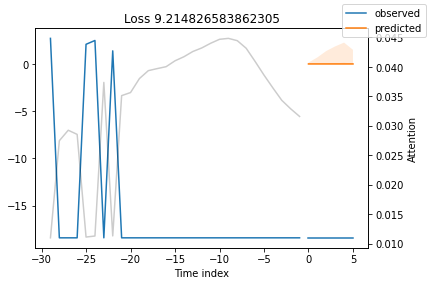

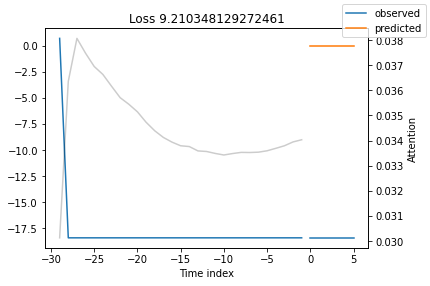

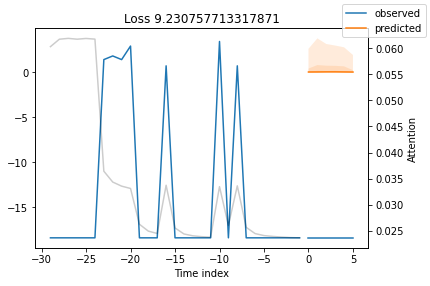

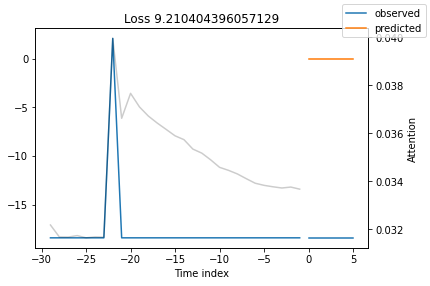

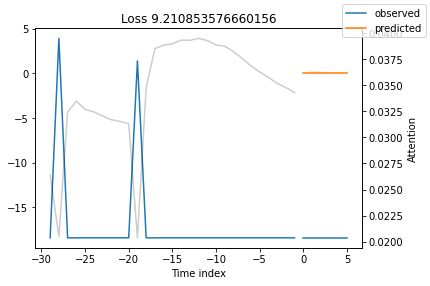

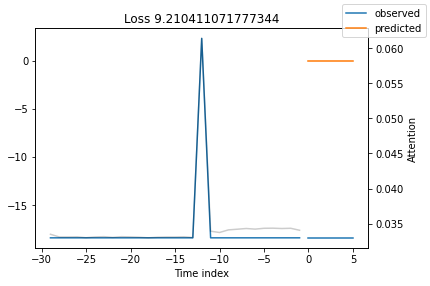

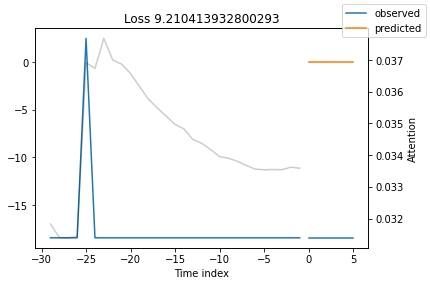

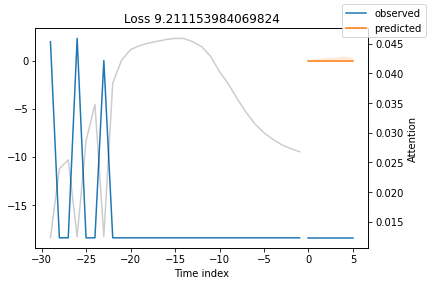

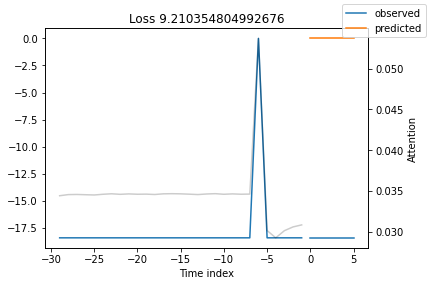

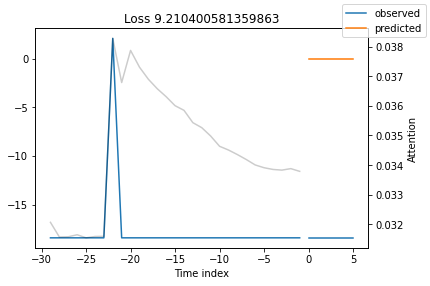

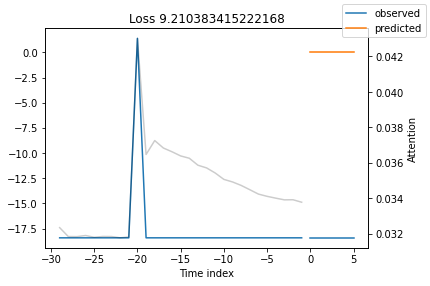

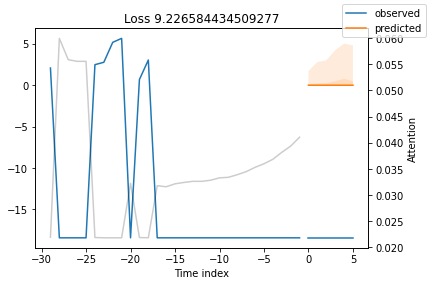

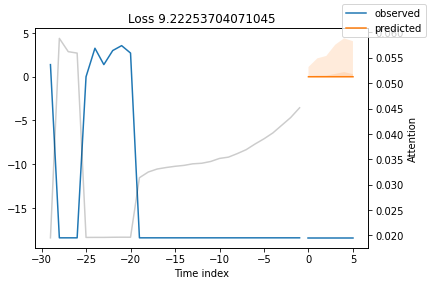

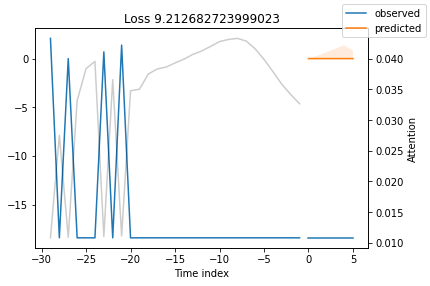

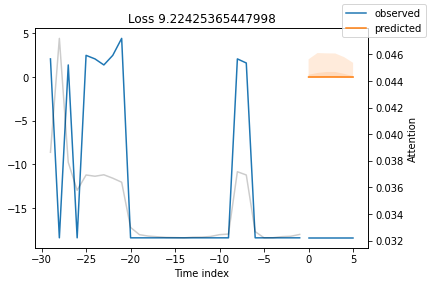

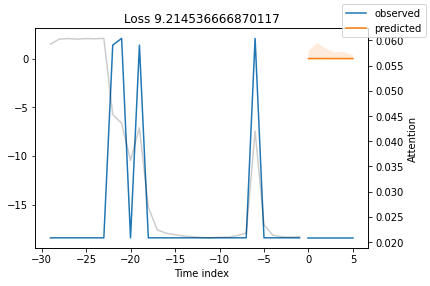

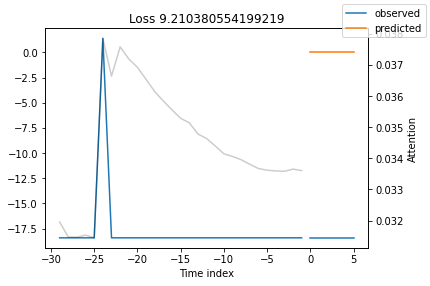

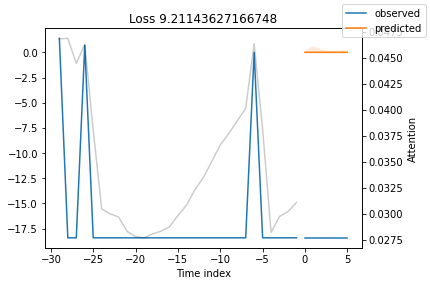

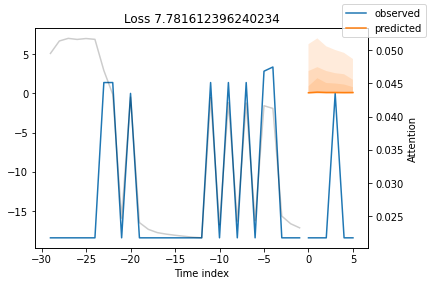

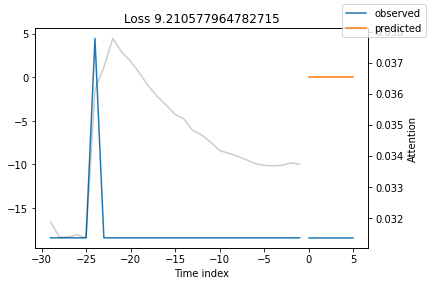

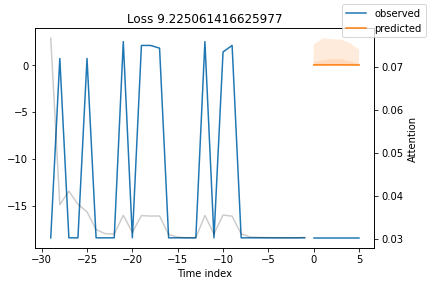

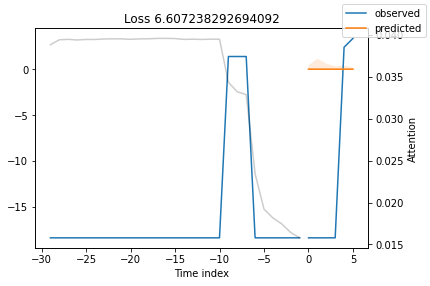

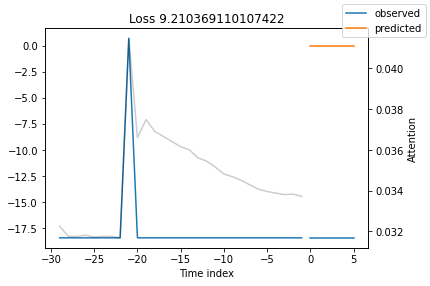

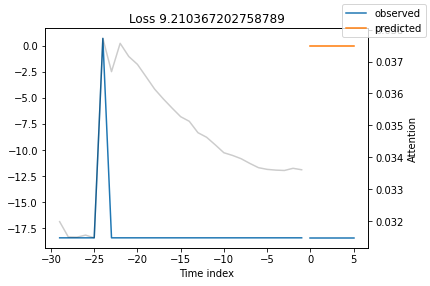

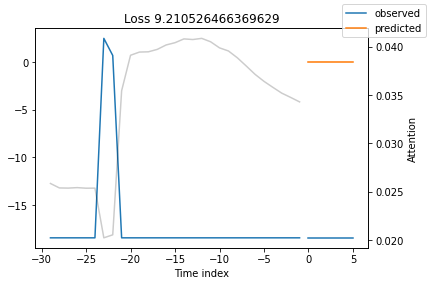

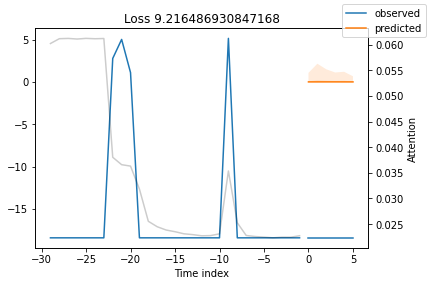

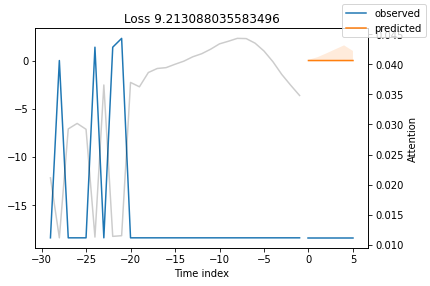

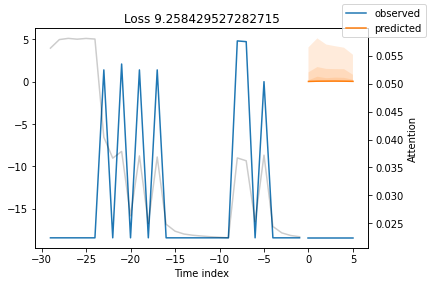

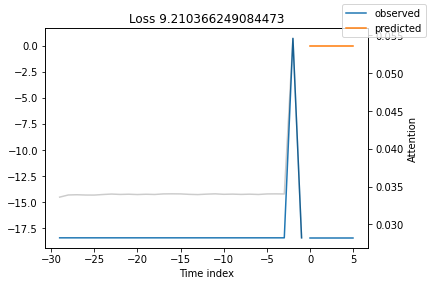

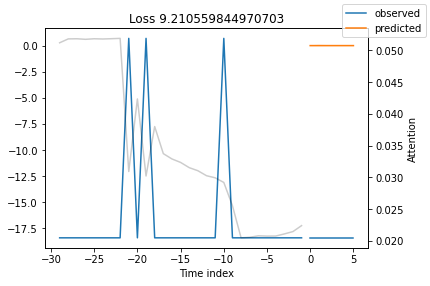

In [ ]:
for idx in range(30):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

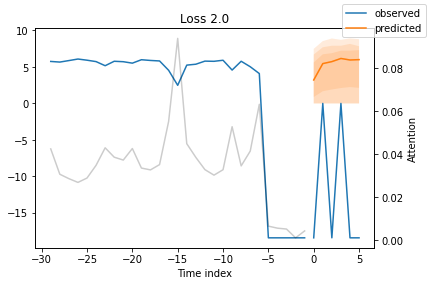

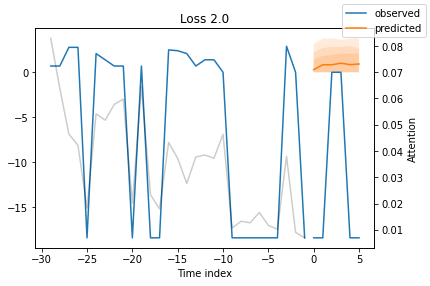

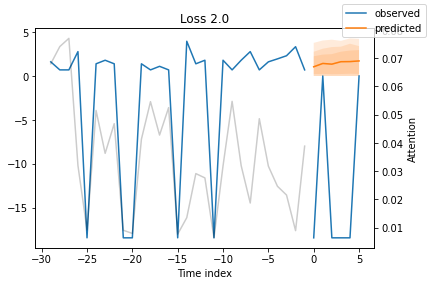

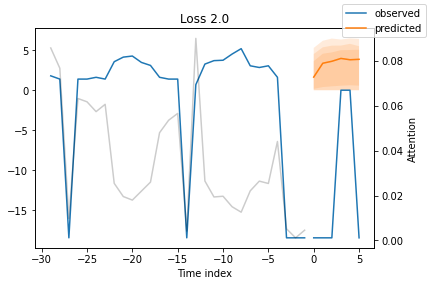

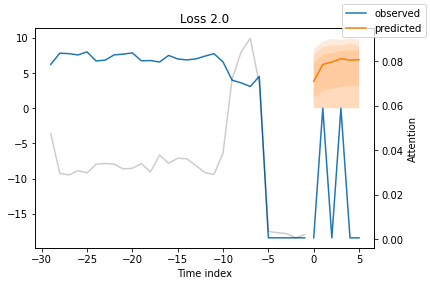

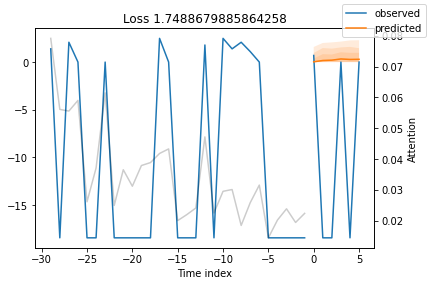

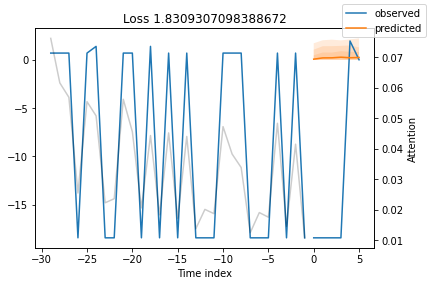

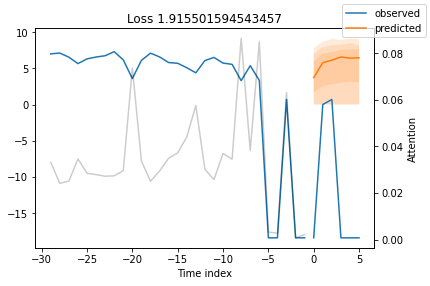

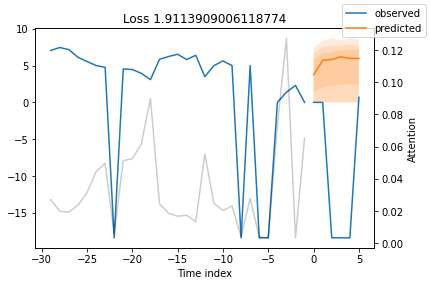

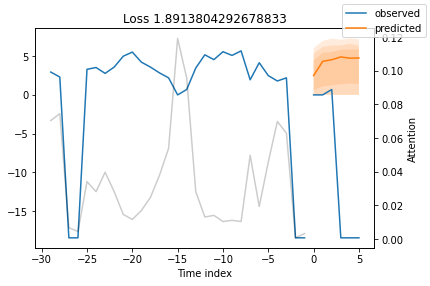

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );